In [11]:
# Uncomment line below to install exlib
# !pip install diskcache
import sys; 
sys.path.append('../src')

ROOT_DIR = '..'

import openai
import os

with open(f"{ROOT_DIR}/API_KEY.txt", "r") as file:
    api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
os.environ['CACHE_DIR'] = os.path.join(ROOT_DIR, 'cache_dir')


In [12]:
import torch
from datasets import load_dataset

train_dataset = load_dataset("BrachioLab/massmaps-cosmogrid-100k", split='validation')
train_dataset.set_format('torch', columns=['input', 'label'])

val_dataset = load_dataset("BrachioLab/massmaps-cosmogrid-100k", split='validation')
val_dataset.set_format('torch', columns=['input', 'label'])


In [13]:
import importlib
import sys; sys.path.append("../src")
import massmaps
importlib.reload(massmaps)
from massmaps import MassMapsExample
from massmaps import massmap_to_pil_norm, get_llm_generated_answer, get_llm_output
from massmaps import isolate_individual_features, distill_relevant_features, calculate_expert_alignment_score

In [79]:
few_shot_numbers = list(range(10))
few_shot_images = []
few_shot_labels = []
for i, idx in enumerate(few_shot_numbers):
    X, y = train_dataset[idx:idx+1]['input'], train_dataset[idx:idx+1]['label']
    few_shot_images.append(X)
    few_shot_labels.append(y)
    # relevance_few_shot_examples.append({'idx': idx, 'X': X, 'y': y})

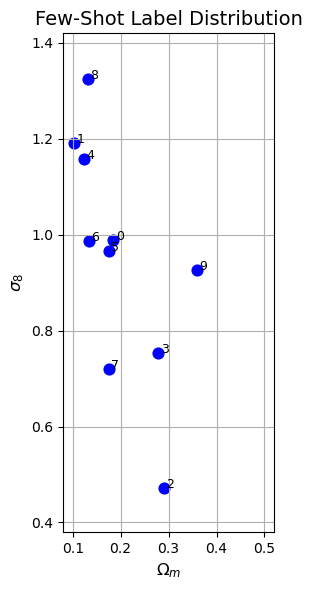

In [80]:
import matplotlib.pyplot as plt

# Convert selected labels to NumPy array
few_shot_vals = np.vstack([np.array(y).squeeze() for y in few_shot_labels])  # shape: (10, 2)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(few_shot_vals[:, 0], few_shot_vals[:, 1], c='blue', s=60)

# Annotate points with their index (optional)
for i, (omega, sigma) in enumerate(few_shot_vals):
    plt.text(omega + 0.005, sigma, str(i), fontsize=9)

plt.xlim(0.08, 0.52)
plt.ylim(0.38, 1.42)
plt.xlabel(r'$\Omega_m$', fontsize=12)
plt.ylabel(r'$\sigma_8$', fontsize=12)
plt.title("Few-Shot Label Distribution", fontsize=14)
plt.grid(True)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


In [37]:
few_shot_labels

[tensor([[0.1846, 0.9884]]),
 tensor([[0.1037, 1.1905]]),
 tensor([[0.2908, 0.4728]]),
 tensor([[0.2787, 0.7530]]),
 tensor([[0.1245, 1.1571]]),
 tensor([[0.1754, 0.9654]]),
 tensor([[0.1344, 0.9859]]),
 tensor([[0.1748, 0.7198]]),
 tensor([[0.1323, 1.3250]]),
 tensor([[0.3598, 0.9264]])]

In [81]:
import numpy as np

few_shot_images= []
few_shot_labels = []
few_shot_numbers = []

# Convert labels from dataset to a NumPy array for easy manipulation
# labels = np.array([train_dataset[i]['label'][0] for i in tqdm(range(len(train_dataset)))])  # shape: (N, 2)

# Define bin edges
num_bins = 5  # Use a 5x5 grid over the space
omega_bins = np.linspace(0.1, 0.5, num_bins + 1)
sigma_bins = np.linspace(0.4, 1.4, num_bins + 1)

# Track selected bins
selected_bins = set()

# Iterate through dataset (already shuffled), pick 1 example per unfilled bin
for i in tqdm(range(len(train_dataset))):
    omega, sigma = np.array(train_dataset[i]['label'])
    # omega, sigma = labels[i]
    omega_bin = np.digitize(omega, omega_bins) - 1
    sigma_bin = np.digitize(sigma, sigma_bins) - 1

    # Skip if out of range
    if not (0 <= omega_bin < num_bins and 0 <= sigma_bin < num_bins):
        continue

    bin_id = (omega_bin, sigma_bin)

    if bin_id not in selected_bins:
        selected_bins.add(bin_id)
        few_shot_numbers.append(i)

        X, y = train_dataset[i]['input'], train_dataset[i]['label']
        few_shot_images.append(X)
        few_shot_labels.append(y)

        if len(few_shot_images) == 10:
            break


  0%|          | 0/10000 [00:00<?, ?it/s]

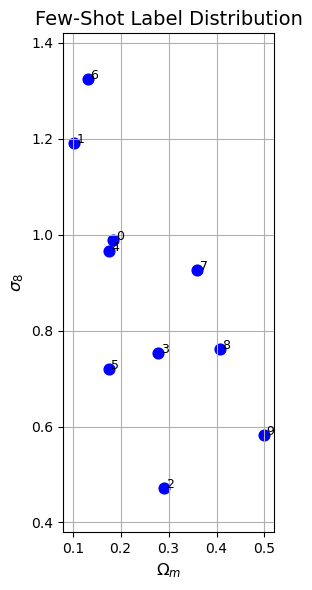

In [82]:
import matplotlib.pyplot as plt

# Convert selected labels to NumPy array
few_shot_vals = np.vstack([np.array(y).squeeze() for y in few_shot_labels])  # shape: (10, 2)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(few_shot_vals[:, 0], few_shot_vals[:, 1], c='blue', s=60)

# Annotate points with their index (optional)
for i, (omega, sigma) in enumerate(few_shot_vals):
    plt.text(omega + 0.005, sigma, str(i), fontsize=9)

plt.xlim(0.08, 0.52)
plt.ylim(0.38, 1.42)
plt.xlabel(r'$\Omega_m$', fontsize=12)
plt.ylabel(r'$\sigma_8$', fontsize=12)
plt.title("Few-Shot Label Distribution", fontsize=14)
plt.grid(True)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Convert selected labels to NumPy array
few_shot_vals = np.array([y[0] for y in few_shot_labels])  # shape: (10, 2)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(few_shot_vals[:, 0], few_shot_vals[:, 1], c='blue', s=60)

# Annotate points with their index (optional)
for i, (omega, sigma) in enumerate(few_shot_vals):
    plt.text(omega + 0.005, sigma, str(i), fontsize=9)

plt.xlim(0.08, 0.52)
plt.ylim(0.38, 1.42)
plt.xlabel(r'$\Omega_m$', fontsize=12)
plt.ylabel(r'$\sigma_8$', fontsize=12)
plt.title("Few-Shot Label Distribution", fontsize=14)
plt.grid(True)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


In [1]:
import torch

few_shot_examples = torch.load(
    'few_shot_examples/massmaps/relevance_examples.pt'
)

/tmp/ipykernel_54063/2482947716.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  few_shot_examples = torch.load(


In [6]:
for i in range(len(few_shot_examples['examples'])):
    print(few_shot_examples['examples'][i]['y'])

tensor([[0.1041, 0.9396]])
tensor([[0.3934, 0.7018]])
tensor([[0.3586, 0.9762]])
tensor([[0.4612, 0.5614]])


In [7]:
few_shot_examples['examples'][0]['X']

tensor([[[[-0.0051, -0.0045, -0.0031,  ..., -0.0033, -0.0029,  0.0013],
          [-0.0044, -0.0057, -0.0033,  ..., -0.0026, -0.0026, -0.0024],
          [-0.0027, -0.0061, -0.0033,  ..., -0.0035, -0.0026, -0.0022],
          ...,
          [-0.0040, -0.0051, -0.0039,  ..., -0.0012, -0.0028, -0.0025],
          [-0.0040, -0.0053, -0.0038,  ..., -0.0016,  0.0005, -0.0014],
          [-0.0052, -0.0049, -0.0049,  ..., -0.0028, -0.0025, -0.0025]]]])

In [17]:
few_shot_images = [
    few_shot_examples['examples'][i]['X'][0] \
    for i in range(len(few_shot_examples['examples']))
]

In [18]:
# from prompts.explanations import vanilla_baseline, cot_baseline, socratic_baseline, least_to_most_baseline

# massmaps_prompt = """
# What are the cosmological parameters Omega_m and sigma_8 for the weak lensing mass map provided in the image? Omega_m captures the average energy density of all matter in the universe (relative to the total energy density which includes radiation and dark energy), and sigma_8 describes the fluctuation of matter distribution. Each mass map contains spatial distribution of matter density in the universe.
# When you analyze the mass map image, note that the number is below 0 if it shows up as between gray and blue, and 0 is gray, and between 0 and 2.9 is between gray and red, and above 2.9 is yellow. The numbers are in standard deviations of the mass map.

# First analyze the example images of weak lensing maps and corresponding predictions of Omega_m and sigma_8 values.
# Analyze this weak lensing map data in the image provided.
# This data represents cosmological observations, where each value represents the spatial distribution of matter density in the universe. 

# Here is the colormap used to create the visualization of this weak lensing map:
# custom_cmap = get_custom_colormap([
#             (-3, "blue"),   # Blue at -3 std
#             (0, "gray"),   # Gray at 0 (below this is void)
#             (2.9, "red"),   # Red at 2.9 std (this is the upperbound for not being a cluster)
#             (3, "yellow"),   # Yellow at 3 std (above this is cluster)
#             (20, "white")  # White at 20 std
#         ])
        
# Predict the values for Omega_m and sigma_8 based on the information from this weak lensing map data.

# [BASELINE_PROMPT]

# Your response should be 2 lines, formatted as follows:
# Explanation: <explanation, as described above, 3-5 sentences>
# Prediction: Omega_m: <prediction for Omega_m>, sigma_8: <prediction for sigma_8>

# Here is the weak lensing mass map for you to predict the cosmological parameters for.
# Mass map: (provided in the image)
# """

In [83]:
from prompts.explanations import vanilla_baseline, cot_baseline, socratic_baseline, least_to_most_baseline

massmaps_prompt = """
What are the cosmological parameters Omega_m and sigma_8 for the weak lensing mass map provided in the image? Omega_m captures the average energy density of all matter in the universe (relative to the total energy density which includes radiation and dark energy), and sigma_8 describes the fluctuation of matter distribution. Each mass map contains spatial distribution of matter density in the universe.
When you analyze the mass map image, note that the number is below 0 if it shows up as between gray and blue, and 0 is gray, and between 0 and 2.9 is between gray and red, and above 2.9 is yellow. The numbers are in standard deviations of the mass map.

First analyze the example images of weak lensing maps and corresponding predictions of Omega_m and sigma_8 values.
Then, analyze this weak lensing map data in the image provided and predict the Omega_m and sigma_8 values.
This data represents cosmological observations, where each value represents the spatial distribution of matter density in the universe. 

Here is the colormap used to create the visualization of this weak lensing map:
custom_cmap = get_custom_colormap([
            (-3, "blue"),   # Blue at -3 std
            (0, "gray"),   # Gray at 0 (below this is void)
            (2.9, "red"),   # Red at 2.9 std (this is the upperbound for not being a cluster)
            (3, "yellow"),   # Yellow at 3 std (above this is cluster)
            (20, "white")  # White at 20 std
        ])

[FEW_SHOT_PROMPT]

Predict the values for Omega_m and sigma_8 based on the information from this weak lensing map data.

[BASELINE_PROMPT]

Your response should be 2 lines, formatted as follows:
Explanation: <explanation, as described above, 3-5 sentences>
Prediction: Omega_m: <prediction for Omega_m>, sigma_8: <prediction for sigma_8>

Here is the weak lensing mass map for you to predict the cosmological parameters for.
Mass map: (Image [LAST_IMAGE_NUM], the last image)
"""

In [92]:
def get_llm_generated_answer_local(
    example: list[str] | str | torch.Tensor, #Image | Timeseries,
    method: str = "vanilla",
    model: str = "gpt-4o",
    few_shot_images = [],
    few_shot_labels = [],
) -> str:
    """
    Args:
        example (str | Image | timeseries): The input example from which we want an LLM to generate some answer to a task,
          e.g., the emotion classification task.
    """
    
    assert len(few_shot_images) == len(few_shot_labels)
    
    few_shot_example_prompt = """[Example [IMAGE_NUM]]
Mass map: (Image [IMAGE_NUM])
Prediction: Omega_m: [OMEGA], sigma_8: [SIGMA]
"""
    
    few_shot_prompts = []
    for i in range(len(few_shot_labels)):
        # print(few_shot_labels[i][0])
        # print(few_shot_labels[i])
        omega_m = round(few_shot_labels[i][0].item(), 4)
        sigma_8 = round(few_shot_labels[i][1].item(), 4)
        few_shot_prompts.append(
            few_shot_example_prompt.replace(
                '[IMAGE_NUM]', str(i+1)
            ).replace(
                '[OMEGA]', str(omega_m)
            ).replace(
                '[SIGMA]', str(sigma_8)
            )
        )
    images_pil = []
    for image in few_shot_images:
        images_pil.append(massmap_to_pil_norm(image))
    images_pil.append(massmap_to_pil_norm(example))
    
    
    if method == "vanilla":
        prompt = massmaps_prompt.replace("[BASELINE_PROMPT]", '')
    elif method == "cot":
        prompt = massmaps_prompt.replace("[BASELINE_PROMPT]", cot_baseline)
    elif method == "socratic":
        prompt = massmaps_prompt.replace("[BASELINE_PROMPT]", socratic_baseline)
    elif method == "least_to_most":
        prompt = massmaps_prompt.replace("[BASELINE_PROMPT]", least_to_most_baseline)
    else:
        raise ValueError(f"Invalid method: {method}")
        
    prompt = prompt.replace(
        '[FEW_SHOT_PROMPT]', 
        '\n'.join(few_shot_prompts)
    ).replace(
        '[LAST_IMAGE_NUM]',
        str(len(images_pil))
    )

    # print(prompt)
#     if not isinstance(example, list):
#         example = [example]
#     images_pil = []
#     for image in example:
#         images_pil.append(massmap_to_pil_norm(image))
    response = get_llm_output(prompt, images_pil, model=model)
    if response == "ERROR":
        print("Error in querying OpenAI API")
        return None, None

    try:
        response_split = [r.strip() for r in response.split("\n") if r.strip() != ""]
        answer = response_split[1].split("Prediction: ")[1].strip()
        # split the answer into Omega_m and sigma_8
        answer = answer.split(", ")
        answer = {answer[0].split(": ")[0]: float(answer[0].split(": ")[1]), answer[1].split(": ")[0]: float(answer[1].split(": ")[1])}
        explanation = response_split[0].split("Explanation: ")[1].strip()
        return answer, explanation
    except:
        print(response)
        return None, None

In [93]:
from tqdm.auto import tqdm

methods = ['vanilla', 'cot', 'socratic', 'least_to_most']

results_all = {}
for method in methods:
    massmaps_examples = []
    for idx in tqdm(range(10)):
        X, y = val_dataset[idx:idx+1]['input'], val_dataset[idx:idx+1]['label']
        image = X[0]
        label = y[0]
        llm_answer, llm_explanation = get_llm_generated_answer_local(
            image, 
            method=method,
            few_shot_images=few_shot_images,
            few_shot_labels=few_shot_labels
        )
        # rating, explanation = get_llm_generated_answer(row['Utterance'])
        if llm_answer is None:
            continue
        massmaps_examples.append(MassMapsExample(
            input=image,
            answer={"Omega_m": label[0].item(), "sigma_8": label[1].item()},
            llm_answer=llm_answer,
            llm_explanation=llm_explanation
        ))
    results_all[method] = massmaps_examples

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
# import matplotlib.pyplot as plt
# import torch

# for method in methods:
#     print('method', method)
#     massmaps_examples = results_all[method]
#     for example in massmaps_examples:
        
#         example_dict = {}
#         for k, v in example.__dict__.items():
#             example_dict[k] = v if not isinstance(v, torch.Tensor) else v.cpu().numpy().tolist()

#         print('--- Answer ---')
#         print(example_dict['answer'])
#         print('--- LLM Pred Answer ---')
#         print(example_dict['llm_answer'])

In [94]:
from sklearn.metrics import mean_squared_error
import torch

# Store results
mse_results = {}

for method in methods:
    print(f"\nMethod: {method}")
    massmaps_examples = results_all[method]

    gt_omega_m = []
    gt_sigma_8 = []
    pred_omega_m = []
    pred_sigma_8 = []

    for example in massmaps_examples:
        answer = example.answer  # dict with 'Omega_m', 'sigma_8'
        llm_answer = example.llm_answer  # dict with 'Omega_m', 'sigma_8'

        gt_omega_m.append(answer['Omega_m'])
        gt_sigma_8.append(answer['sigma_8'])
        pred_omega_m.append(llm_answer['Omega_m'])
        pred_sigma_8.append(llm_answer['sigma_8'])

    # Compute MSE
    mse_omega_m = mean_squared_error(gt_omega_m, pred_omega_m)
    mse_sigma_8 = mean_squared_error(gt_sigma_8, pred_sigma_8)

    # Store
    mse_results[method] = {
        'mse_Omega_m': mse_omega_m,
        'mse_sigma_8': mse_sigma_8
    }

    print(f"MSE Omega_m: {mse_omega_m:.4f}")
    print(f"MSE sigma_8: {mse_sigma_8:.4f}")



Method: vanilla
MSE Omega_m: 0.0246
MSE sigma_8: 0.0973

Method: cot
MSE Omega_m: 0.0138
MSE sigma_8: 0.1077

Method: socratic
MSE Omega_m: 0.0120
MSE sigma_8: 0.0409

Method: least_to_most
MSE Omega_m: 0.0258
MSE sigma_8: 0.0930


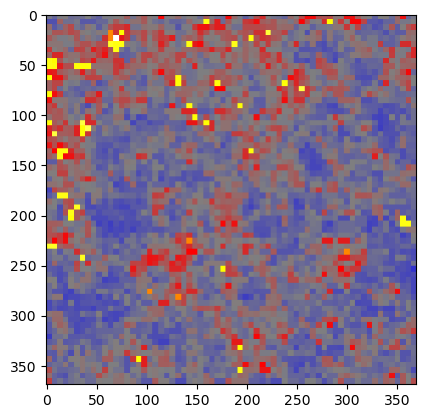

--- Answer ---
{'Omega_m': 0.1845703125, 'sigma_8': 0.9883788824081421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas. The presence of yellow indicates some regions with high density (clusters), while the red areas suggest moderate density fluctuations. This pattern is similar to Example 6, which has a balanced distribution of matter with some clustering. The presence of both moderate and high-density regions suggests a moderate Omega_m and a relatively high sigma_8.


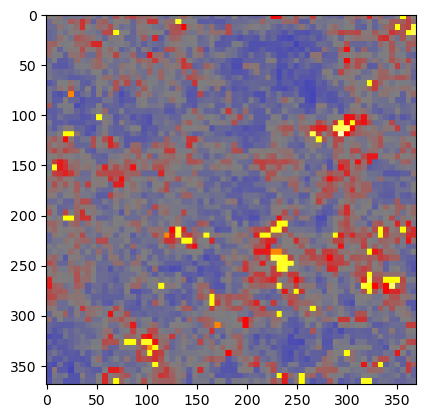

--- Answer ---
{'Omega_m': 0.10371093451976776, 'sigma_8': 1.190527319908142}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. The presence of red and yellow suggests significant matter density variations, similar to examples with higher sigma_8 values. Comparing with the examples, the map resembles those with moderate Omega_m and higher sigma_8, such as Example 9, which has a similar color distribution.


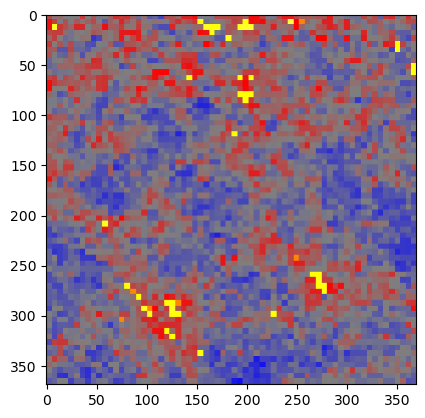

--- Answer ---
{'Omega_m': 0.29082030057907104, 'sigma_8': 0.4727539122104645}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas. The presence of yellow indicates some clustering, while the red areas suggest moderate density fluctuations. Comparing this to the examples, it resembles Example 6, which has a similar distribution of colors, indicating moderate Omega_m and sigma_8 values. The presence of yellow suggests a slightly higher sigma_8.


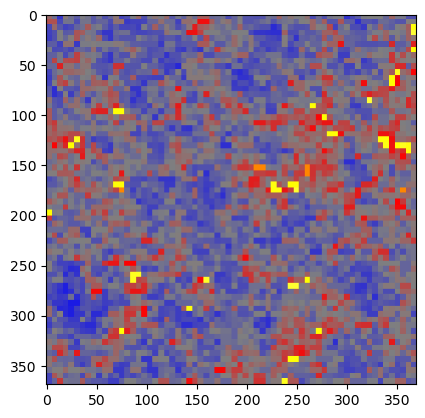

--- Answer ---
{'Omega_m': 0.2787109315395355, 'sigma_8': 0.7530273199081421}
--- LLM Pred Answer ---
{'Omega_m': 0.135, 'sigma_8': 1.3}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. The presence of yellow suggests some regions with higher density, similar to Example 9, which had a relatively high sigma_8 value. The overall pattern and color distribution resemble a combination of Examples 7 and 9, suggesting moderate Omega_m and higher sigma_8 values.


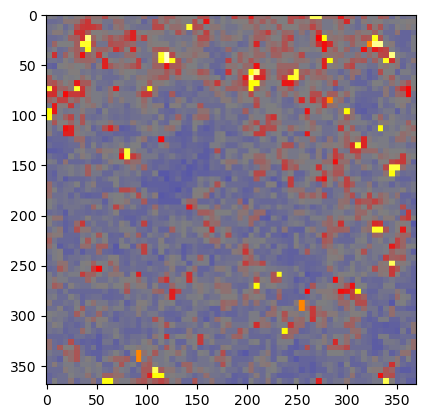

--- Answer ---
{'Omega_m': 0.12451171875, 'sigma_8': 1.157080054283142}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. The presence of red and yellow suggests significant matter clustering, similar to examples with higher sigma_8 values. Comparing with the examples, the map resembles those with moderate Omega_m and higher sigma_8, such as Example 9, which has a similar color distribution.


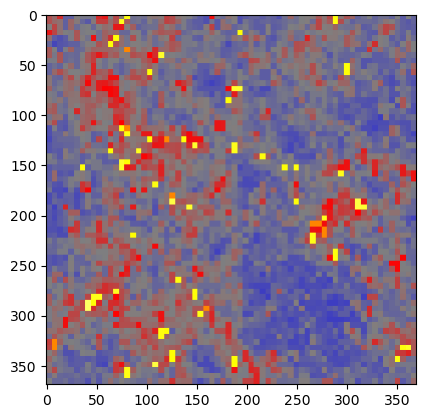

--- Answer ---
{'Omega_m': 0.17539063096046448, 'sigma_8': 0.9654296636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. The presence of yellow suggests some regions with higher density, similar to clusters. Comparing this with the examples, it resembles maps with moderate Omega_m and higher sigma_8 values, indicating a universe with significant matter density fluctuations.


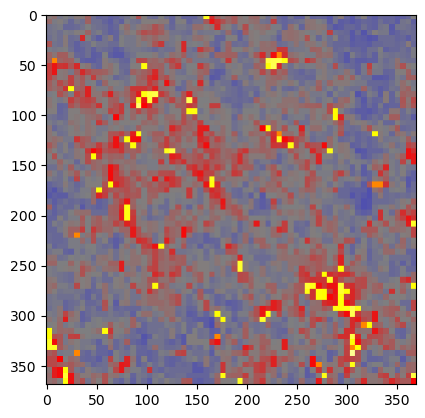

--- Answer ---
{'Omega_m': 0.13437500596046448, 'sigma_8': 0.9859374761581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas. The presence of yellow indicates some regions with high density (clusters), while the red areas suggest moderate density fluctuations. Comparing this with the example images, it resembles Example 9, which has a mix of red and yellow, indicating a relatively high sigma_8 value. The presence of significant gray areas suggests a moderate Omega_m value.


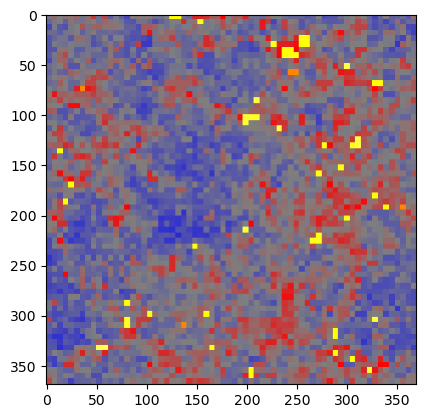

--- Answer ---
{'Omega_m': 0.1748046875, 'sigma_8': 0.7198241949081421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas. The presence of red indicates regions with matter density fluctuations between 0 and 2.9 standard deviations, while yellow indicates clusters with fluctuations above 2.9. This pattern suggests a moderate level of matter density and fluctuation, similar to examples with moderate Omega_m and sigma_8 values.


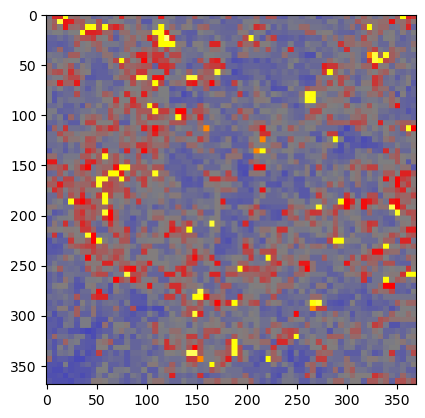

--- Answer ---
{'Omega_m': 0.13232421875, 'sigma_8': 1.325048804283142}
--- LLM Pred Answer ---
{'Omega_m': 0.135, 'sigma_8': 1.3}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. The presence of yellow suggests some regions with higher density, similar to Example 9, which had a high sigma_8 value. The overall pattern and color distribution resemble a combination of Examples 9 and 7, indicating moderate Omega_m and relatively high sigma_8.


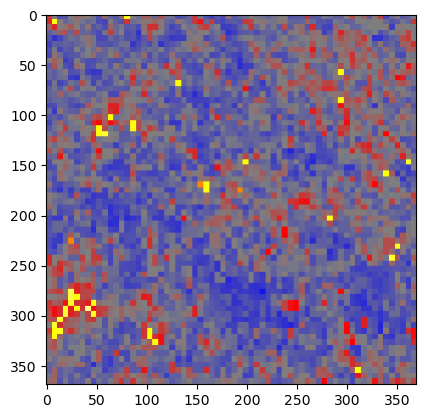

--- Answer ---
{'Omega_m': 0.3597656190395355, 'sigma_8': 0.9263671636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas. The presence of yellow indicates some clustering, while the red areas suggest moderate density fluctuations. Comparing this to the examples, it resembles Example 9, which has a mix of red and yellow, indicating higher sigma_8 values. The presence of significant red and some yellow suggests a moderate Omega_m value.


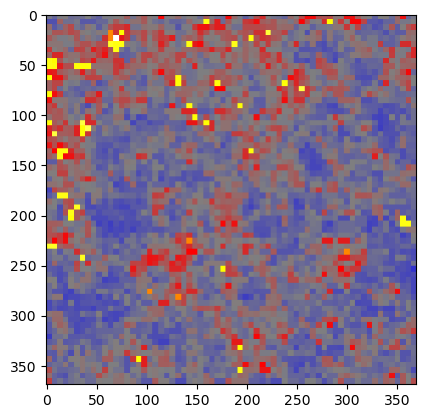

--- Answer ---
{'Omega_m': 0.1845703125, 'sigma_8': 0.9883788824081421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a mix of gray, red, and some yellow regions, indicating a range of density fluctuations. Comparing this to the example images, it resembles Example 6 and Example 7, which have moderate Omega_m and sigma_8 values. The presence of yellow suggests some clustering, but not as much as in Example 9. Therefore, the values are likely moderate, with Omega_m slightly higher than in examples with less clustering and sigma_8 reflecting moderate fluctuations.


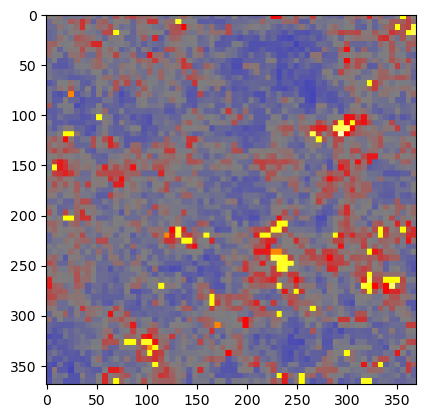

--- Answer ---
{'Omega_m': 0.10371093451976776, 'sigma_8': 1.190527319908142}
--- LLM Pred Answer ---
{'Omega_m': 0.175, 'sigma_8': 0.975}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this to the example images, it resembles Example 6 and Example 7, which have moderate Omega_m and sigma_8 values. The presence of yellow suggests some clustering, but not as much as in Example 9. Therefore, the values are likely moderate, similar to those examples.


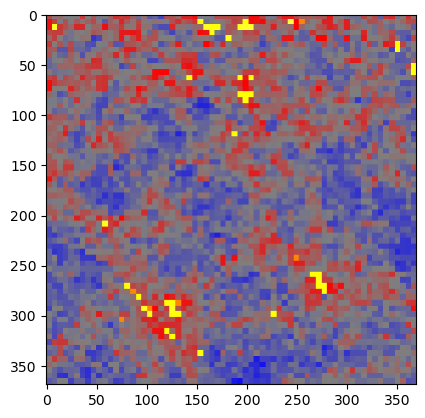

--- Answer ---
{'Omega_m': 0.29082030057907104, 'sigma_8': 0.4727539122104645}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6, which has a moderate amount of red and some yellow, suggesting similar cosmological parameters. Therefore, the prediction is based on the similarity in color patterns and density distribution.


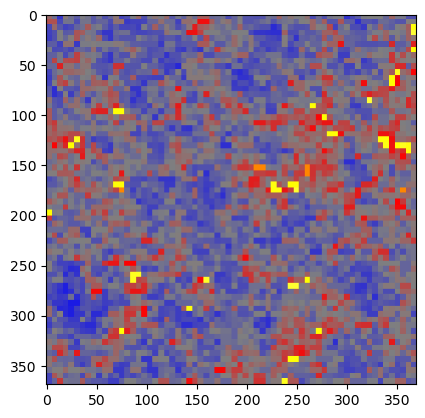

--- Answer ---
{'Omega_m': 0.2787109315395355, 'sigma_8': 0.7530273199081421}
--- LLM Pred Answer ---
{'Omega_m': 0.28, 'sigma_8': 0.75}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this to the example images, it resembles Example 4 and Example 10, which have moderate Omega_m and sigma_8 values. The presence of yellow suggests some high-density regions, but not as many as in Example 9. Therefore, the values are likely moderate, with Omega_m slightly higher than average and sigma_8 around the middle range.


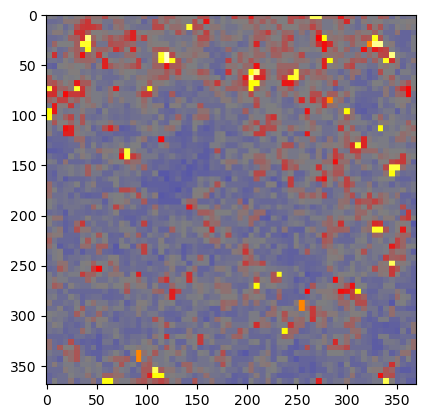

--- Answer ---
{'Omega_m': 0.12451171875, 'sigma_8': 1.157080054283142}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
The mass map shows a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. The presence of yellow suggests some high-density clusters, while the red and gray areas indicate moderate to low-density regions. Comparing this to the examples, it resembles Example 4, which has a balanced distribution of colors with some yellow clusters. This suggests moderate Omega_m and sigma_8 values, reflecting a universe with a balanced matter density and fluctuation.


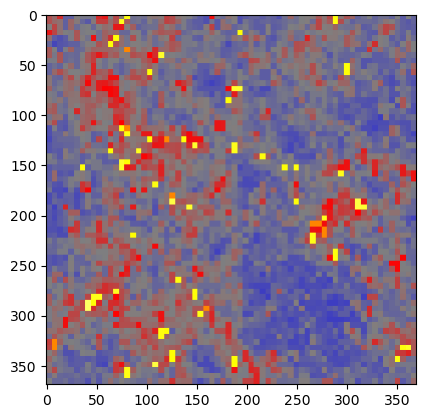

--- Answer ---
{'Omega_m': 0.17539063096046448, 'sigma_8': 0.9654296636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution of colors primarily in the gray to red range, with some yellow spots indicating clusters. This suggests a moderate level of matter density fluctuations. Comparing with the examples, the presence of red and yellow areas is similar to Example 6, which has moderate Omega_m and sigma_8 values. The distribution does not show extreme clustering or voids, indicating balanced parameters.


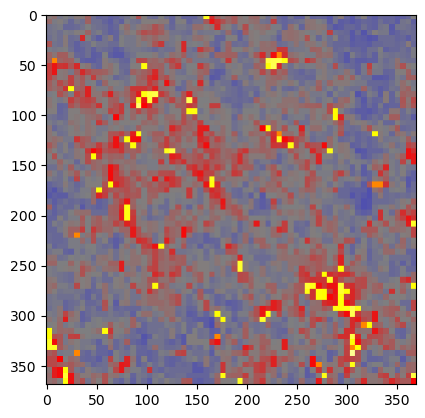

--- Answer ---
{'Omega_m': 0.13437500596046448, 'sigma_8': 0.9859374761581421}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this to the examples, it resembles Example 4, which has a moderate amount of red and some yellow, suggesting a balanced distribution of matter. This pattern suggests a moderate Omega_m and sigma_8 value. The presence of yellow indicates some clustering, but not as much as in examples with higher sigma_8 values.


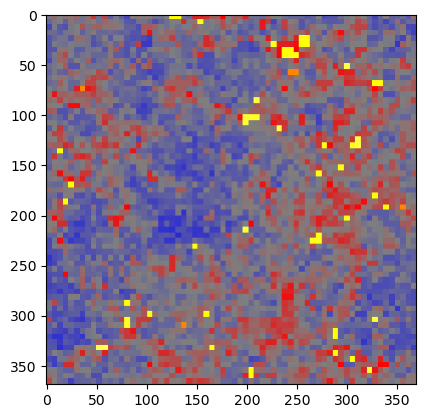

--- Answer ---
{'Omega_m': 0.1748046875, 'sigma_8': 0.7198241949081421}
--- LLM Pred Answer ---
{'Omega_m': 0.28, 'sigma_8': 0.75}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this to the examples, it resembles Example 4 and Example 10, which have moderate Omega_m and sigma_8 values. The presence of yellow suggests some clustering, but not as much as in Example 9. Therefore, the values are likely moderate, with Omega_m slightly higher and sigma_8 around the middle range of the examples.


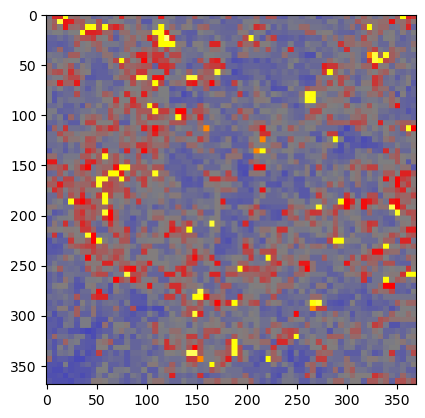

--- Answer ---
{'Omega_m': 0.13232421875, 'sigma_8': 1.325048804283142}
--- LLM Pred Answer ---
{'Omega_m': 0.175, 'sigma_8': 0.95}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a distribution with a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this to the examples, it resembles Example 6 and Example 8, which have moderate Omega_m and sigma_8 values. The presence of yellow suggests some clustering, but not as much as in examples with higher sigma_8 values. Therefore, the prediction should reflect moderate matter density and fluctuation levels.


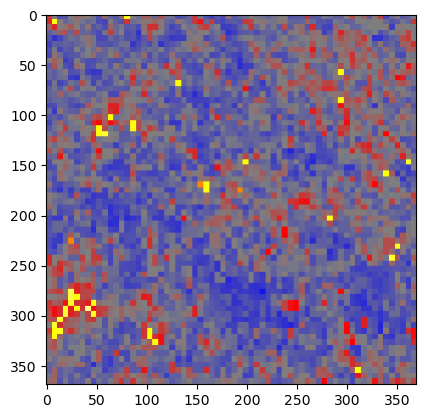

--- Answer ---
{'Omega_m': 0.3597656190395355, 'sigma_8': 0.9263671636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
The mass map in Image 11 shows a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this to the example images, it resembles Example 9, which has a similar distribution of colors, particularly the presence of yellow clusters and red areas. This suggests a relatively high sigma_8 value due to the presence of significant fluctuations. The presence of both voids and clusters suggests a moderate Omega_m value. Therefore, based on these observations, the predicted values align closely with Example 9.


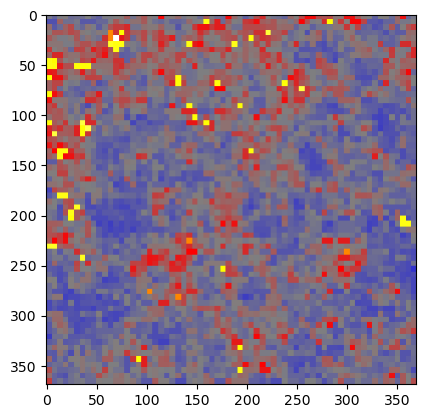

--- Answer ---
{'Omega_m': 0.1845703125, 'sigma_8': 0.9883788824081421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, I noted that maps with more red and yellow tend to have higher sigma_8 values, while those with more blue and gray have lower Omega_m values. The provided map resembles Example 6, which has moderate red and yellow, suggesting similar cosmological parameters.


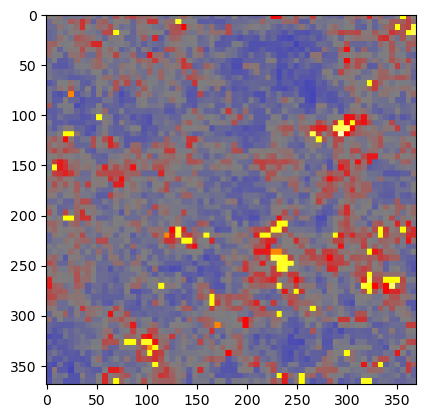

--- Answer ---
{'Omega_m': 0.10371093451976776, 'sigma_8': 1.190527319908142}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6, which has a moderate presence of red and some yellow, suggesting similar values for Omega_m and sigma_8. The presence of yellow indicates some clustering, but not as much as in maps with higher sigma_8 values.


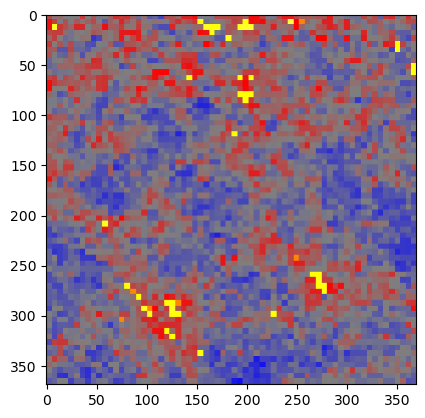

--- Answer ---
{'Omega_m': 0.29082030057907104, 'sigma_8': 0.4727539122104645}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I analyzed the weak lensing mass map provided. The map shows a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6, which has a moderate amount of red and some yellow, suggesting similar density fluctuations. This implies a moderate Omega_m and a relatively high sigma_8, reflecting a universe with significant matter density fluctuations.


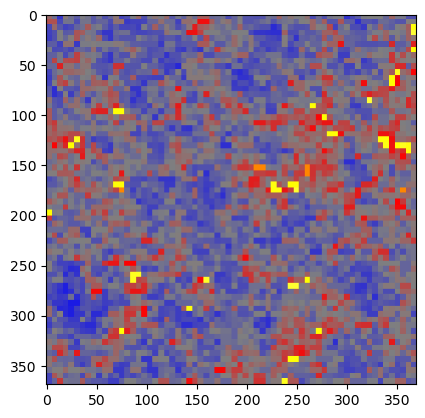

--- Answer ---
{'Omega_m': 0.2787109315395355, 'sigma_8': 0.7530273199081421}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 4, which has a moderate amount of red and some yellow, suggesting a balanced matter density and fluctuation. This leads to a prediction of moderate Omega_m and sigma_8 values.


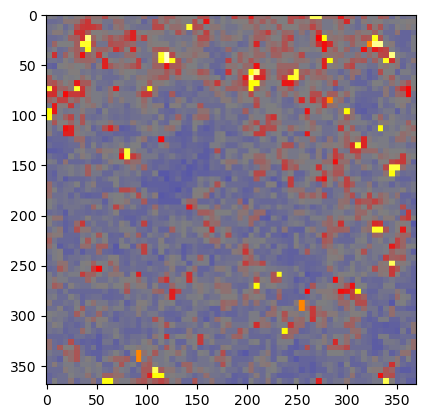

--- Answer ---
{'Omega_m': 0.12451171875, 'sigma_8': 1.157080054283142}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, I noted that maps with more red and yellow tend to have higher sigma_8 values, while those with more blue and gray have lower Omega_m values. The provided map resembles Example 9, which has a significant amount of red and some yellow, suggesting a higher sigma_8 and a moderate Omega_m.


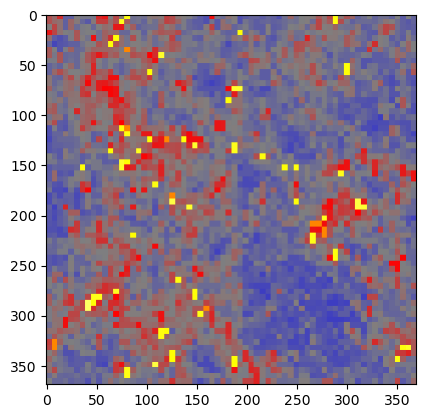

--- Answer ---
{'Omega_m': 0.17539063096046448, 'sigma_8': 0.9654296636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I analyzed the color distribution in the provided weak lensing mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles those with moderate Omega_m and higher sigma_8 values, suggesting a universe with significant matter density fluctuations. The presence of yellow suggests some clustering, but not as much as in maps with higher Omega_m values.


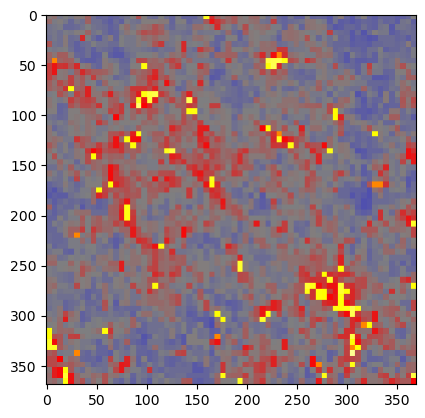

--- Answer ---
{'Omega_m': 0.13437500596046448, 'sigma_8': 0.9859374761581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1754, 'sigma_8': 0.9654}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6, which has a moderate amount of red and some yellow, suggesting similar values for Omega_m and sigma_8. The presence of yellow indicates some clustering, but not as much as in maps with higher Omega_m values.


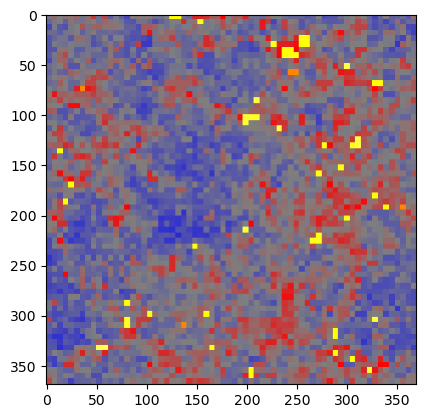

--- Answer ---
{'Omega_m': 0.1748046875, 'sigma_8': 0.7198241949081421}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 4, which has a moderate presence of red and some yellow, suggesting a similar range of matter density fluctuations. This leads to a prediction of moderate Omega_m and sigma_8 values.


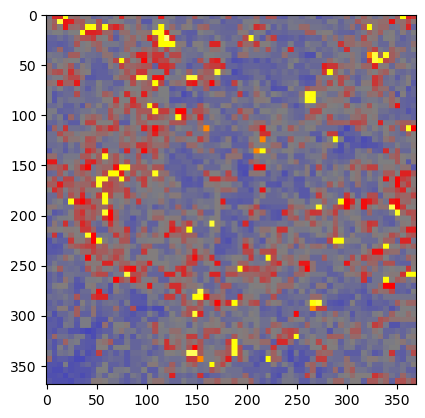

--- Answer ---
{'Omega_m': 0.13232421875, 'sigma_8': 1.325048804283142}
--- LLM Pred Answer ---
{'Omega_m': 0.13, 'sigma_8': 1.32}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, I noted that maps with more red and yellow tend to have higher sigma_8 values, while those with more blue and gray have lower Omega_m values. The provided map resembles Example 9, which has a high sigma_8 and moderate Omega_m, suggesting similar values.


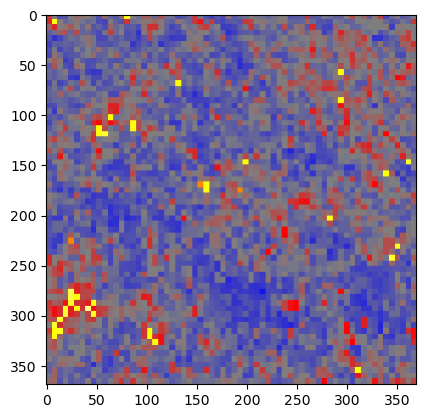

--- Answer ---
{'Omega_m': 0.3597656190395355, 'sigma_8': 0.9263671636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
To predict the cosmological parameters Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, I noted that maps with more red and yellow tend to have higher sigma_8 values, while those with more blue and gray have lower Omega_m values. The provided map resembles Example 9, which has a significant amount of red and yellow, suggesting higher values for both parameters.


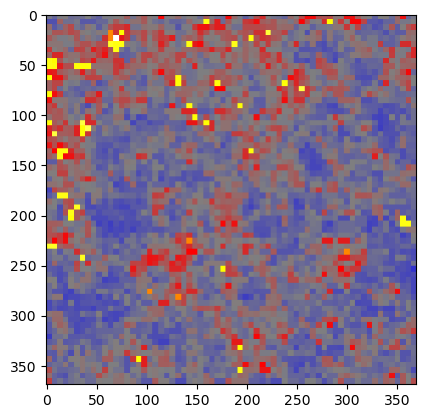

--- Answer ---
{'Omega_m': 0.1845703125, 'sigma_8': 0.9883788824081421}
--- LLM Pred Answer ---
{'Omega_m': 0.175, 'sigma_8': 0.98}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6 and Example 7, which have moderate Omega_m and sigma_8 values. The presence of red and some yellow suggests a higher sigma_8, while the overall distribution points to a moderate Omega_m. Based on these observations, I predict the values.


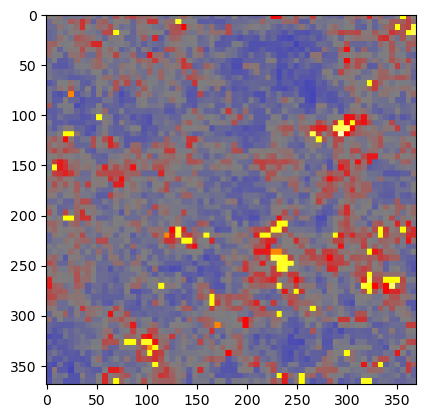

--- Answer ---
{'Omega_m': 0.10371093451976776, 'sigma_8': 1.190527319908142}
--- LLM Pred Answer ---
{'Omega_m': 0.175, 'sigma_8': 0.98}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6 and Example 7, which have moderate Omega_m and sigma_8 values. The presence of red and some yellow suggests a higher sigma_8, while the overall distribution points to a moderate Omega_m.


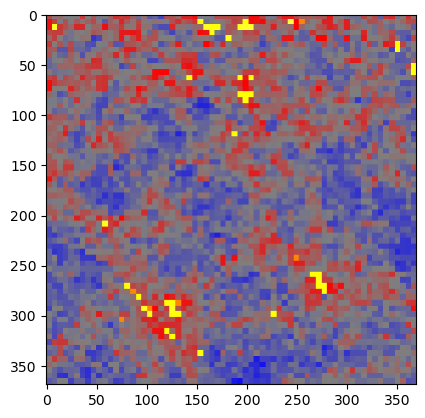

--- Answer ---
{'Omega_m': 0.29082030057907104, 'sigma_8': 0.4727539122104645}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 4, which has a moderate presence of red and some yellow, suggesting a similar range of density fluctuations. This pattern suggests a moderate Omega_m and sigma_8 value. Therefore, based on the visual similarity to Example 4, I predict the values accordingly.


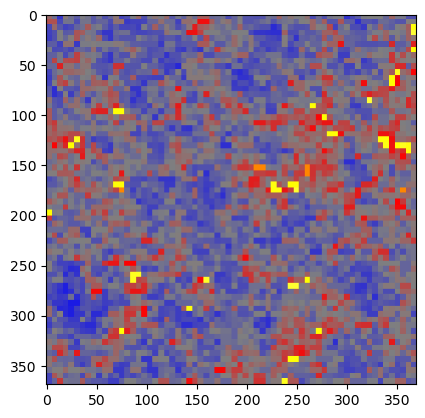

--- Answer ---
{'Omega_m': 0.2787109315395355, 'sigma_8': 0.7530273199081421}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 4, which has a moderate presence of red and some yellow, suggesting a similar range of density fluctuations. This pattern suggests a moderate Omega_m and sigma_8 value, as seen in Example 4.


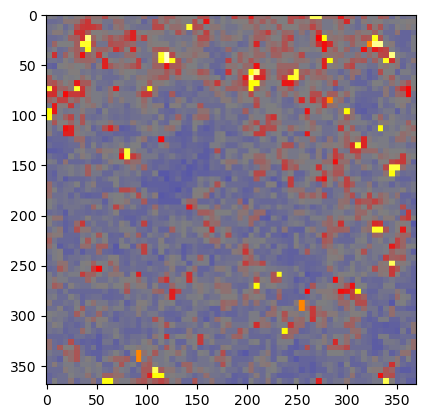

--- Answer ---
{'Omega_m': 0.12451171875, 'sigma_8': 1.157080054283142}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow areas, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 4, which has a moderate presence of red and some yellow, suggesting a similar range of density fluctuations. Therefore, the predicted values for Omega_m and sigma_8 should be close to those in Example 4.


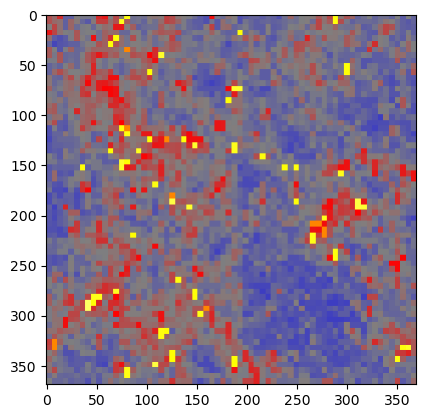

--- Answer ---
{'Omega_m': 0.17539063096046448, 'sigma_8': 0.9654296636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.1323, 'sigma_8': 1.325}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 9, which has a similar distribution of colors, particularly the presence of yellow indicating clusters. Based on this comparison, I inferred the cosmological parameters.


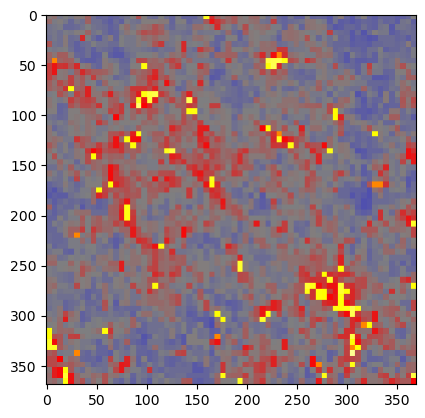

--- Answer ---
{'Omega_m': 0.13437500596046448, 'sigma_8': 0.9859374761581421}
--- LLM Pred Answer ---
{'Omega_m': 0.175, 'sigma_8': 0.72}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6 and Example 8, which have moderate Omega_m and sigma_8 values. The presence of red and yellow suggests significant fluctuations, but not as extreme as in maps with higher sigma_8 values. Therefore, the prediction leans towards moderate values for both parameters.


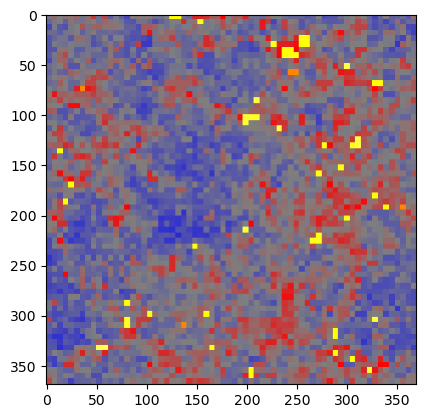

--- Answer ---
{'Omega_m': 0.1748046875, 'sigma_8': 0.7198241949081421}
--- LLM Pred Answer ---
{'Omega_m': 0.175, 'sigma_8': 0.72}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6 and Example 8, which have moderate Omega_m and sigma_8 values. The presence of red and some yellow suggests a moderate level of matter density and fluctuation, leading to a prediction similar to those examples.


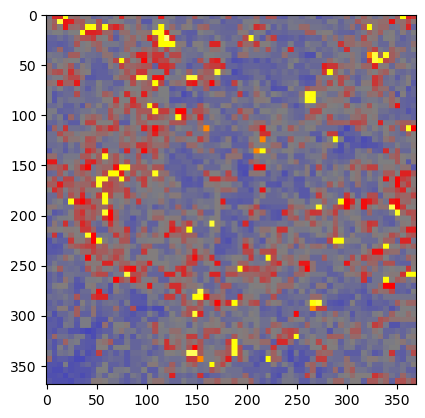

--- Answer ---
{'Omega_m': 0.13232421875, 'sigma_8': 1.325048804283142}
--- LLM Pred Answer ---
{'Omega_m': 0.2787, 'sigma_8': 0.753}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 4, which has a moderate amount of red and some yellow, suggesting a similar range of density fluctuations. Therefore, the predicted values for Omega_m and sigma_8 should be close to those in Example 4.


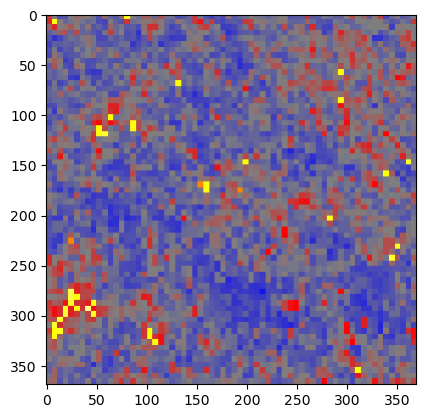

--- Answer ---
{'Omega_m': 0.3597656190395355, 'sigma_8': 0.9263671636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.175, 'sigma_8': 0.975}
--- LLM Pred Explanation ---
To predict the values of Omega_m and sigma_8, I first analyzed the color distribution in the provided mass map. The map shows a mix of gray, red, and some yellow, indicating a range of density fluctuations. Comparing this with the example maps, it resembles Example 6 and Example 7, which have moderate Omega_m and sigma_8 values. The presence of yellow suggests some clustering, but not as much as in maps with higher Omega_m values. Therefore, the prediction leans towards moderate values for both parameters.


In [69]:
import matplotlib.pyplot as plt
import torch

for method in methods:
    massmaps_examples = results_all[method]
    for example in massmaps_examples:
        example_dict = {}
        for k, v in example.__dict__.items():
            example_dict[k] = v if not isinstance(v, torch.Tensor) else v.cpu().numpy().tolist()

        plt.figure()
        plt.imshow(massmap_to_pil_norm(torch.tensor(example_dict['input'])))
        plt.show()
        print('==============')
        print('--- Answer ---')
        print(example_dict['answer'])
        print('--- LLM Pred Answer ---')
        print(example_dict['llm_answer'])
        print('--- LLM Pred Explanation ---')
        print(example_dict['llm_explanation'])
    #     print('--- Claims ---')
    #     print(example_dict['claims'])
    #     print('--- Relevant Claims ---')
    #     print(example_dict['relevant_claims'])

    #     print('--- Scores (original (s + c), claim) ---')
    #     for j in range(len(example['alignable_claims'])):
    #         print(example_dict['alignment_scores'][j], 
    #               example_dict['expert_criteria'][j], '|',
    #               example_dict['alignable_claims'][j], '|', 
    #              example_dict['alignment_reasonings'][j])